## LSTMに関して
時系列データを取り扱う際に、次の状態$t_i$を計算する際、それよりも前の状態$t_{i-1}$を考慮する必要がある。

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

In [6]:
#今回はバッチ学習を行っていく。
#今回行っていくこととしてはsinカーブの予測
#490を学習に使用し、残りを予測に使用する。
x = np.linspace(0 , 499 , 500)
y = np.sin(x * 2 * np.pi / 50)

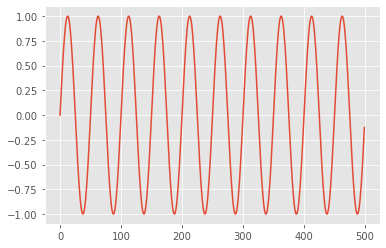

In [7]:
plt.plot(x , y)

In [10]:
#LSTMにデータを入れていく場合、一定のシーケンスに変換したデータ列に変換する必要がある。
#シーケンス長が4だったら4つづつのデータをひとまとめにして入力するということになる。
def make_sequence_data(y , num_sequence):
    num_data = len(y)
    seq_data = []
    target_data = []
    for i in range(num_data - num_sequence):
        seq_data.append(y[i:i + num_sequence])#num_sequenceの数だけまとめている。
        target_data.append(y[i+num_sequence:i+num_sequence+1])#予測する次のデータをappendしている。
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)
    return seq_arr , target_arr


In [9]:
#40ずつにまとめている。
seq_length = 40
y_seq , y_target = make_sequence_data(y , seq_length)

In [13]:
y_seq.shape

(460, 40)

In [12]:
#教師データ
y_target.shape

(460, 1)

In [14]:
num_test = 10
y_seq_train = y_seq[:-num_test]
y_seq_test = y_seq[-num_test:]
y_target_train = y_target[:-num_test]
y_target_test = y_target[-num_test:]

In [17]:
y_seq_train

array([[ 0.00000000e+00,  1.25333234e-01,  2.48689887e-01, ...,
        -9.98026728e-01, -9.98026728e-01, -9.82287251e-01],
       [ 1.25333234e-01,  2.48689887e-01,  3.68124553e-01, ...,
        -9.98026728e-01, -9.82287251e-01, -9.51056516e-01],
       [ 2.48689887e-01,  3.68124553e-01,  4.81753674e-01, ...,
        -9.82287251e-01, -9.51056516e-01, -9.04827052e-01],
       ...,
       [-3.68124553e-01, -2.48689887e-01, -1.25333234e-01, ...,
        -9.04827052e-01, -9.51056516e-01, -9.82287251e-01],
       [-2.48689887e-01, -1.25333234e-01, -2.20436424e-15, ...,
        -9.51056516e-01, -9.82287251e-01, -9.98026728e-01],
       [-1.25333234e-01, -2.20436424e-15,  1.25333234e-01, ...,
        -9.82287251e-01, -9.98026728e-01, -9.98026728e-01]])

In [18]:
y_seq_train.shape


(450, 40)

In [28]:
#Tensor型に変更を行う。
#学習用のデータ。
y_seq_t = torch.FloatTensor(y_seq_train)
y_target_t = torch.FloatTensor(y_target_train)


In [40]:
class LSTM(nn.Module):
    def __init__(self , hidden_size):#LSTMの隠れ層の数を指定している、
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=1,hidden_size=self.hidden_size)#40シーケンス長を持った一次元のベクトルを一つわたすのでinput_size=1となる。
        self.linear = nn.Linear(self.hidden_size,1)#hiddensizeを一つのデータに絞る。
   
    def forward(self , x):
        x , _ = self.lstm(x)#LSTMはシーケンス長のアウトプットと隠れ層やセルの状態をまとまったもの
        x_last = x[-1]#-1にすることによって一番最後のデータを返してくれる。シーケンス長の予測された値の最後の値を持ってきている。
        x = self.linear(x_last)#最後の値をlinearに入れている。
        return x

In [42]:
model = LSTM(100)

In [43]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr = 0.001)

In [29]:
y_seq_t.size()

torch.Size([450, 40])

In [30]:
#LSTMにインプットする際にはシーケンス長の軸、バッチサイズの軸、インプットサイズの順番になっている必要がある。
#そのため、並び替える。
y_seq_t = y_seq_t.permute(1,0)
y_target_t = y_target_t.permute(1,0)


In [31]:
y_seq_t.size()
#このままだとまだ二次元でしかないが、入力の軸を増やす必要がある。

torch.Size([40, 450])

In [32]:
y_seq_t = y_seq_t.unsqueeze(dim=-1 )#dim=-1で一番最後に軸が付与される。
y_target_t = y_target_t.unsqueeze(dim=-1 )#dim=-1で一番最後に軸が付与される。

In [33]:
y_seq_t.size()

torch.Size([40, 450, 1])

In [44]:
#学習を行っていく。

num_epochs = 80 
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(y_seq_t)
    loss = criterion(output , y_target_t)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 10 == 0:
        print("epoch: {} , loss : {}  ".format(epoch , loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 450, 1])) that is different to the input size (torch.Size([450, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 , loss : 0.5209078192710876  
epoch: 10 , loss : 0.3823237121105194  
epoch: 20 , loss : 0.2320566475391388  
epoch: 30 , loss : 0.0474386103451252  
epoch: 40 , loss : 0.011509465985000134  
epoch: 50 , loss : 0.008055604994297028  
epoch: 60 , loss : 0.002602754393592477  
epoch: 70 , loss : 0.0020455424673855305  


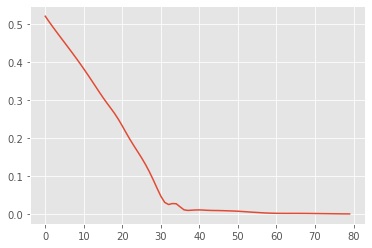

In [46]:
plt.plot(losses)

In [49]:
#予測を行う。
y_seq_test_t = torch.FloatTensor(y_seq_test)
y_seq_test_t = y_seq_test_t.permute(1,0)
y_seq_test_t = y_seq_test_t.unsqueeze(dim=-1)

In [51]:
y_seq_test_t.size()

torch.Size([40, 10, 1])

In [53]:
y_pred = model(y_seq_test_t)

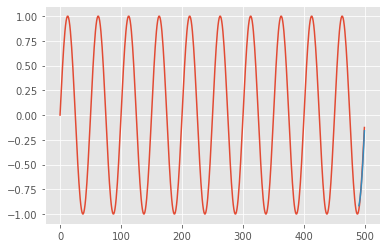

In [54]:
plt.plot(x,y)
plt.plot(np.arange(490 , 500) , y_pred.detach())